# Cogo Data Science technical interview task: Explore relationships

From the introductory document:

>## What will the format be?

>We have prepared a coding task that we would like you to prepare for the interview. You will find the data and the data dictionary attached. The data consists of 2070 rows of Cogo app users (1 row per user), their demographic data as well as their sustainability values (badges) and the climate actions they committed to in the app (actions). If a person has selected a sustainability badge, or committed to a climate action, it is marked as 1 , otherwise 0.

>We don’t expect you to spend more than 2 hours on the task!

>This is an exploratory exercise and we want you to have fun with the data. We’d like you to work in Python, maybe Jupyter Notebook so you can take us through the code and results on the day of the interview.

>### Here are a couple of suggestions you could be looking at:
>- Exploratory Analysis: Spend some time exploring the data, using some data
visualisation and descriptive statistics. Tell us about interesting things you come
across.
>- Clustering: Can you identify any clusters in the Badge data, or Action data? Can you
infer one from the other? If you find any clusters in the data, how would you interpret
those?
>- Application: Based on your findings, what are some recommendations you would
take to the product team?

## What is in this notebook?

This notebook contains an analysis of the relationships between the demographic, action and badge variables provided in `Interview2_DataChallenge.csv`.

If I have time I might do some unsupervised machine learning to provide some deeper insight.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from lib import USER_DATA_PATH

In [2]:
user_data = pd.read_pickle(USER_DATA_PATH)

## Visualise the relationships between variables

If this data was primarily continuous then tradition would dictate that I would use a `seaborn.pairplot` at this stage, to visualise the relationships between the columns across all combinations of pairs.

Instead, I'm going to (try to) compute the ratio of conditional probabilities which, like a correlation for continuous variables, is a measure of the association between binary variables. I'll then visualise that with a heatmap. Hopefully that will be a bit more informative.

**I have my fingers crossed that this information will prove useful for serving action suggestions to users based on their demographic information and badges.**

First we will encode both the `gender` and `age` with a one-hot encoding so that they are binary variables as well.

In [3]:
# here we replace the NA values in `age` with 'age_unknown' because having NAs in the column names doesn't feel like a good idea
# we'll then turn those intervals into strings so I can index against them a bit more easily
gender_age_onehot = pd.concat([
    pd.get_dummies(user_data.gender, prefix = 'gender'),
    pd.get_dummies(user_data.age.astype('object').fillna('unknown').astype(str), prefix = 'age')],
    axis = 1)
# keep the gender and age names for later
gender_age_onehot_names = gender_age_onehot.columns.tolist()
gender_age_onehot

,gender_Female,gender_Male,gender_Other/Unknown,"age_[18.0, 29.0]","age_[31.0, 40.0]","age_[41.0, 55.0]","age_[56.0, 100.0]",age_unknown
0,1,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0
3,1,0,0,1,0,0,0,0
4,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2065,0,0,1,0,0,0,0,1
2066,1,0,0,1,0,0,0,0
2067,1,0,0,1,0,0,0,0
2068,0,0,1,0,0,0,0,1


In [4]:
# just to check that worked, the sum in axis = 1 should all equal 2
assert (gender_age_onehot.sum(axis = 1) == 2).all()

Now we can concatenate our one-hot encodings with the actions and badges to get our fully binaryized data.

We will also remove the `badge_inv` column because it is not going to provide us with any insight into behaviour (in this sample nobody chose that badge).

In [5]:
action_names = [n for n in user_data.columns if n.startswith('action')]
badge_names = [n for n in user_data.columns if n.startswith('badge')]

user_data_onehot = pd.concat([gender_age_onehot, user_data[action_names + badge_names]], axis = 1)
user_data_onehot = user_data_onehot.drop('badge_inv', axis = 1)

# remember to remove the `badge_inv` entry from `badge_names`
badge_names.remove('badge_inv')

## The conditional probability ratio: an example

As an example I'll compute the probability of `action_vegan=1` given `age_[18.0, 29.0]=0` and the conditional probability of `action_vegan=1` given `age_[18.0, 29.0]=1`.

In $LateX$ style:

Let the events:

$ (\text{action_vegan} = 1) = A $

$ (\text{age_[18.0, 29.0]} = 1) = B $

and

$ (\text{age_[18.0, 29.0]} = 0) = \neg B $

Then the two conditional probabilities are:

$ P(A | \neg B) = \frac{P(A \cap \neg B)}{P(\neg B)}$

and:

$ P(A | B) = \frac{P(A \cap B)}{P(B)}$

The ratio:

$ \frac{P(A | B)}{P(A | \neg B)} $

then tells us how much _more likely_ a user of age under 30 is to commit to a vegan diet, compared to someone over 30.

Interpretation:
* If the conditional probability ratio is equal to 1 then the two conditional probabilities are equal, then we know that a user is equaly likely to choose $A$ given $\neg B$ or $B$ 
* If the conditional probability ratio is above 1 then we know the user is more likely to choose $A$ if they also chose $B$
* If the conditional probability ratio is below 1 then we know the user is more likely to choose $A$ if they also chose $\neg B$

In [6]:
under_30 = user_data_onehot['age_[18.0, 29.0]']
action_vegan = user_data_onehot['action_vegan']

# first we compute the contingency table for these two variables
contingency_table = pd.crosstab(under_30, action_vegan)
contingency_table

action_vegan,0,1
"age_[18.0, 29.0]",,
0,771,215
1,712,372


In [7]:
# then we compute the conditional probabilites
conditional_probs = contingency_table[1] / contingency_table.sum(axis = 1)
conditional_probs

age_[18.0, 29.0]
0    0.218053
1    0.343173
dtype: float64

In [8]:
# finally, we compute the ratio of these values
conditional_prob_ratio = conditional_probs[1] / conditional_probs[0]
conditional_prob_ratio

1.5738093194885439

We see that a user who is under 30 is 1.6 times _more_ likely to commit to becoming vegan than a user who is over 30.

I'm going to apply this to identify how likely a user is to choose an action given their badges and demographics.

In [9]:
def compute_conditional_prob_ratio(event_A, given_event_B):
    """ Compute the conditional probability ratio: P(event_A = 1 | given_event_B = 1) / P(event_A = 1 | given_event_B = 0)
    
        Assumes both event_A and given_event_B are pandas Series. 
    """
    
    # these conditions result in the denominator of the ratio being 0 
    # that is the conditional probability of P(event_A = 1 | given_event_A = 0) which is 0 by definition
    # the ratio will be infinite and not very meaningful
    if event_A.name == given_event_B.name:
        return pd.NA
    
    contingency_table = pd.crosstab(given_event_B, event_A)
    conditional_prob = contingency_table[1] / contingency_table.sum(axis = 1)
    return conditional_prob[1] / conditional_prob[0]

# very lightweight test against the example above
compute_conditional_prob_ratio(user_data_onehot['action_vegan'], user_data_onehot['age_[18.0, 29.0]'])

1.5738093194885439

In [10]:
conditional_prob_ratios = pd.DataFrame(
    index = pd.Index(user_data_onehot.drop(action_names, axis = 1).columns, name = 'given_event'),
    columns = pd.Index(action_names, name = 'event'),
    dtype = 'float64')

for event_name, event_col in user_data_onehot[action_names].iteritems():
    for given_event_name, given_event_col in user_data_onehot.drop(action_names, axis = 1).iteritems():
        conditional_prob_ratios.loc[given_event_name, event_name] = compute_conditional_prob_ratio(event_col, given_event_col)

<AxesSubplot:xlabel='event', ylabel='given_event'>

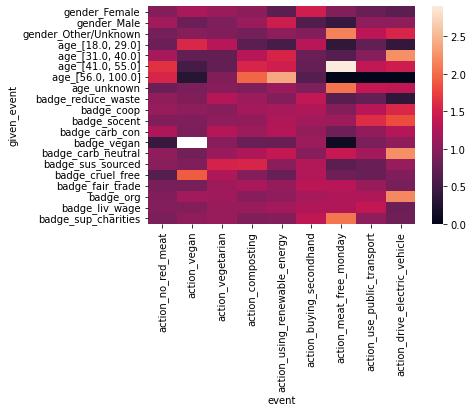

In [11]:
# there is a large outlier that is skewing the colour scale here. Let's get rid of that before plotting
conditional_prob_ratios_for_plot = conditional_prob_ratios.copy()
conditional_prob_ratios_for_plot.loc['badge_vegan', 'action_vegan'] = np.nan

sns.heatmap(conditional_prob_ratios_for_plot)

I don't have a lot of time to interpret this, so let's summarise the highest 10 and lowest 10 as these are good candidates for describing the strongest relationships and potentially feeding into a prediction model of what actions people might choose.

Also, this colormap is a bad choice. One that diverges about 1 would be better for discerning the direction of the relationship.

In [12]:
conditional_prob_ratios_melted = (
    pd.melt(
        conditional_prob_ratios,
        value_name = 'cond_prob',
        ignore_index = False)
    .reset_index()
    .sort_values(by = 'cond_prob')
    .loc[:, ['event', 'given_event', 'cond_prob']] 
)

### Strongest positive relationships

The largest ratio of $ \frac{P(A | B)}{P(A | \neg B)} $

In [13]:
conditional_prob_ratios_top_ten = conditional_prob_ratios_melted.iloc[-10:, :]
conditional_prob_ratios_top_ten

,event,given_event,cond_prob
66,action_composting,"age_[56.0, 100.0]",1.970052
127,action_meat_free_monday,age_unknown,2.049261
139,action_meat_free_monday,badge_sup_charities,2.071704
122,action_meat_free_monday,gender_Other/Unknown,2.135807
177,action_drive_electric_vehicle,badge_org,2.176735
164,action_drive_electric_vehicle,"age_[31.0, 40.0]",2.227545
173,action_drive_electric_vehicle,badge_carb_neutral,2.229656
86,action_using_renewable_energy,"age_[56.0, 100.0]",2.408364
125,action_meat_free_monday,"age_[41.0, 55.0]",2.898879
32,action_vegan,badge_vegan,9.786578


Perhaps unsurprisingly, a user who chooses `badge_vegan` is almost 10 times more likely to choose `action_vegan` than a user who does not choose `badge_vegan`. This is outlier that was skewing our colour palette previously.

Users in the age bracket `[41 , 55]` are close to 3 times more likely to choose `action_meat_free_monday` than those outside of this bracket. 

People in the oldest age bracket `[56, 100]` are 2.4 times more likely to commit to `action_using_renewable_energy`.

People who chose `badge_carb_neutral` are 2.2 times more likely to commit to `action_drive_electric_vehicle`.

Indeed, the top ten is really dominated by the actions `action_meat_free_monday` and `action_drive_electric_vehicle`. This suggests that these actions could maybe be suggested to a user based on their demographic data and badge choices. Could be a candidate for further investigation.

### Strongest negative relationships

The smallest ratio of $ \frac{P(A | B)}{P(A | \neg B)} $

We'll take the reciprocal of this fraction to find: $ \frac{P(A | \neg B)}{P(A | B)} $

This can be interpreted as how much _less_ likely a user is to choose action $A$ given event $B$.

In [14]:
conditional_prob_ratios_bottom_ten = conditional_prob_ratios_melted.iloc[:10].copy()
conditional_prob_ratios_bottom_ten['cond_prob'] = 1. / conditional_prob_ratios_bottom_ten['cond_prob']
conditional_prob_ratios_bottom_ten.sort_values(by = 'cond_prob')

,event,given_event,cond_prob
121,action_meat_free_monday,gender_Male,2.380123
12,action_no_red_meat,badge_vegan,2.384981
163,action_drive_electric_vehicle,"age_[18.0, 29.0]",2.565247
123,action_meat_free_monday,"age_[18.0, 29.0]",2.611055
168,action_drive_electric_vehicle,badge_reduce_waste,2.846390
26,action_vegan,"age_[56.0, 100.0]",3.286517
132,action_meat_free_monday,badge_vegan,9.748495
146,action_use_public_transport,"age_[56.0, 100.0]",inf
166,action_drive_electric_vehicle,"age_[56.0, 100.0]",inf
126,action_meat_free_monday,"age_[56.0, 100.0]",inf


Here we see that users in the age range `[56.0, 100.0]` are extremely unlikely (the `inf` indicates that no-one in the sub-sample has ever chosen that action) to choose `action_use_public_transport`, `action_drive_electric_vehicle` or `action_meat_free_monday`.

However, these users only make up about 1% of the sample so this information is of questionable value.

Perhaps more informatively:

Our age group `[18.0, 29.0]` is about 2.6 times less likely to commit to `action_drive_electric_vehicle`. Due to their age, these users are probably less financially well off and unlikely to drive in the first place.

The behaviour of the `badge_vegan` users is interesting. They are close to 10 times less likely to commit to `action_meat_free_monday` and 2.4 times less likely to commit to `action_no_red_meat`, but from the previous analysis we saw that they were 10 times more likely to commit to `action_vegan`, which contains both of these actions: for a vegan, every Monday is a meat-free Monday. I suppose the vegan users see these options as mutually exlusive rather than thinking of them as a hierarchy.

Similarly to vegans the `gender_Male` users are also less likely to choose meat free Monday. Is that because these guys are already vegetarian/vegan, or because they don't want to stop eating meat even for a day per week?

## Core demographic

In the previous notebook we saw that the core demographic for this app is women under 30 years old. Let's use the technique above to identify if there are any behaviours which separate these users from the rest of the cohort.

In [15]:
# get all actions and badges
event_A_df = user_data_onehot[action_names + badge_names]
# get women under 30 (boolean Series)
given_event_B = (user_data_onehot['age_[18.0, 29.0]'] + user_data_onehot['gender_Female']) == 2

# compute conditional probabilities
conditional_prob_ratios_core_demo = pd.Series(index = event_A_df.columns , dtype = 'float64')
for event_name, event_col in event_A_df.iteritems():
    conditional_prob_ratios_core_demo[event_name] = compute_conditional_prob_ratio(event_col, given_event_B)
conditional_prob_ratios_core_demo = conditional_prob_ratios_core_demo.sort_values() 
conditional_prob_ratios_core_demo

action_meat_free_monday          0.436274
action_drive_electric_vehicle    0.479901
action_using_renewable_energy    0.487107
action_use_public_transport      0.709419
action_composting                0.742745
action_no_red_meat               0.826060
badge_carb_neutral               0.881296
badge_coop                       0.953689
badge_socent                     0.994081
badge_carb_con                   0.998452
badge_org                        1.021526
badge_liv_wage                   1.030778
badge_sus_sourced                1.056589
badge_reduce_waste               1.056988
badge_fair_trade                 1.121453
badge_cruel_free                 1.246135
action_vegetarian                1.258993
badge_sup_charities              1.267213
badge_vegan                      1.365455
action_vegan                     1.404313
action_buying_secondhand         1.449498
dtype: float64

Recall that values less than 1 indicate this demographic is _less_ likely to have the badge or commit to an action than those users outside of the demographic.

Values more than 1 indicate this demographic is _more_ likely to have the badge or commit to an action than those users outside of the demographic.

From this we see that the female under 30 users are more likely to choose `badge_vegan` and more likely to commit to `action_vegan` or `action_buying_secondhand` than those outside of the demographic.

On the other hand, we see that these users are less likely to commit to `action_meat_free_monday`, `action_drive_electric_vehicle` or `action_using_renewable_energy` than those outside of the core demographic.

Further work might involve generating the confidence interval of these values using a bootstrapping method, but for the time being I'd like to move on to a way of identifying clustered variables. 

## Principal component analysis

Principal component analysis is a technique often used to reduce the number of features prior to some model fitting. It results in a series of orthogonal principal components which (in total) contain all of the variance of the original data. Dimensionality reduction is acheived by choosing the components which contain only the majority of the variance. 

Instead of using it for dimensionality reduction here I will apply it to attempt to visualise the relationships between the variables in the data sample. Each principal component explains a known amount of the variance within the dataset. Some of the variables will have a strong linear relationship with a particular principal component and some variables will have relationships with other principal components. 

What is interesting for us is that if two variables have a strong relationship with a particular principal component, then it's likely that they will also be related to _each other_. This is especially true if the component explains a lot of the variance. This leads to a technique which can be used to identify groups of variables with strong relationships between all of the variables in the group.

I'm not going to use the `age` and `gender` onehot encodings to fit the PCA. These fields contain mutually exclusive entries, so we will waste a couple of the principal components describing that pattern. I will correlate the principal components against these variables though.

We start by fitting and transforming data to principal components using sklearn. 

In [25]:
retain_variance = 0.9
pca = PCA(n_components = retain_variance)
user_data_onehot_pca = pd.DataFrame(pca.fit_transform(user_data_onehot.drop(gender_age_onehot_names, axis = 1)),
                                    columns = pca.get_feature_names_out())

print(f'Using {pca.n_components_} principal retains {retain_variance * 100}% of the variance.')

Using 15 principal retains 90.0% of the variance.


Essentially this means we could reduce the number of features from 21 to 15 using this method and still retain 90% of the variance in the data.

Using the function in the next code block I'll try to demonstrate how this technique is useful for identifying demographic data, actions and badges which tend to be grouped together into clusters.

In [26]:
def interpret_principal_component(data, pca_data, pca_name):
    """ For easy interpretation of the principal components.
    
        Plots a line plot of the strength of the relationship between the chosen principal component and 
        the variables in `data`.
        
        For each variable  in `data`, the strength is computed by taking the mean of the principal component 
        when that variable is equal to 1 and subtracting the mean of the principal component when the variable is
        equal to 0.
        
        The graphs is ordered by the strength of the relationship, with strong negative relationships on the left
        and strong positive relationships on the right.
        
        This function also prints the frequency of coincidence (eg. they are all 0 OR all 1) of the three variables 
        with strongest negative relationships, and the frequency of coincidence of the three variables with 
        strongest positive relationships.
        
        This is to demonstrate that this technique can indeed inform you of variables which tend to vary
        concurrently.
    
        Arguments
        ---------
        
        data : pd.DataFrame containing the data from which the principal components were derived
        pca_data : pd.DataFrame containing the principal components
        pca_name : the name of the principal component you would like to interpret
        
    """

    data_plus_pca_data = pd.concat([data, pca_data[pca_name]], axis = 1)
    plot_df = pd.melt(
        data_plus_pca_data,
        id_vars = pca_name,)

    mean_pca_by_variable_and_value = (
        plot_df
        .groupby(['variable', 'value'])
        .mean()
        .groupby(level = 'variable')
        .agg(lambda x: x[1] - x[0])
        .sort_values(by = pca_name))

    fig, ax = plt.subplots(figsize = (15, 8))
    sns.pointplot(
        data = mean_pca_by_variable_and_value.reset_index(),
        x = 'variable',
        y = pca_name,
        ax = ax)

    _ = plt.xticks(rotation = 45, ha = 'right')
    ax.set_title(pca_name)
    ax.grid(which = 'both')
    
    top_three_coincidence = 100 * (data[mean_pca_by_variable_and_value.index[-3:]].sum(axis = 1).isin([0, 3])).sum() / user_data.shape[0]
    bottom_three_coincidence = 100 * (data[mean_pca_by_variable_and_value.index[:3]].sum(axis = 1).isin([0, 3])).sum() / user_data.shape[0]
    
    print(f'In {top_three_coincidence:0.1f}% of users, the top three variables are all equal')
    print(f'In {bottom_three_coincidence:0.1f}% of users, the bottom three variables are all equal')

In 59.3% of users, the top three variables are all equal
In 62.6% of users, the bottom three variables are all equal


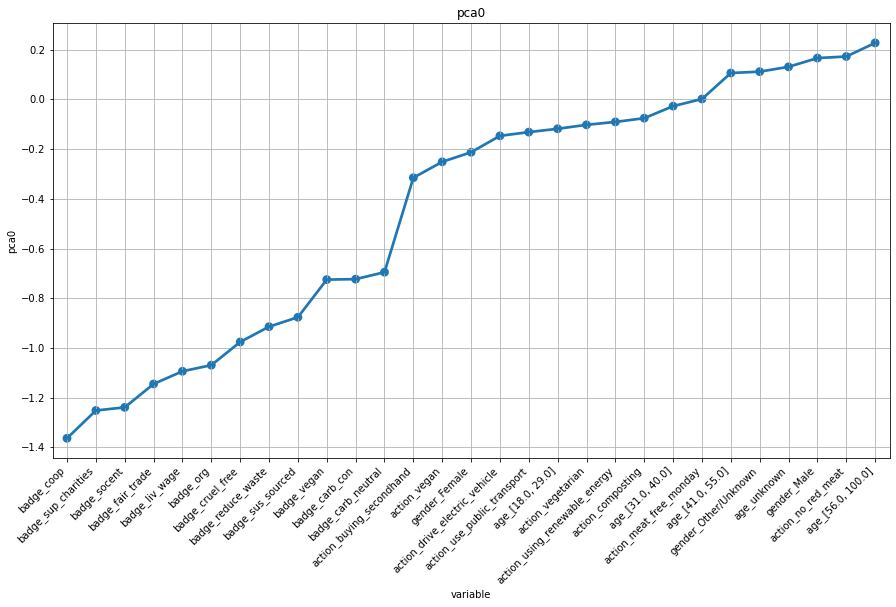

In [22]:
interpret_principal_component(user_data_onehot, user_data_onehot_pca, 'pca0')

We see that for the combination of `gender_Male`, `action_no_red_meat` and ` age_[56.0, 100.0]` in 59% of users these fields are either all equal to 0 or all equal to 1.

If we are thinking about what suggestions to give to users for actions, then we might consider reserving the `action_no_red_meat` option for older males.

On the flip side, if a user decides not to provide their age `age_unknown`, but does provide `gender_Male` and chooses the `action_no_red_meat`, then we might assume that this user is in the older part of our demographic.

In 43.4% of users, the top three variables are all equal
In 42.7% of users, the bottom three variables are all equal


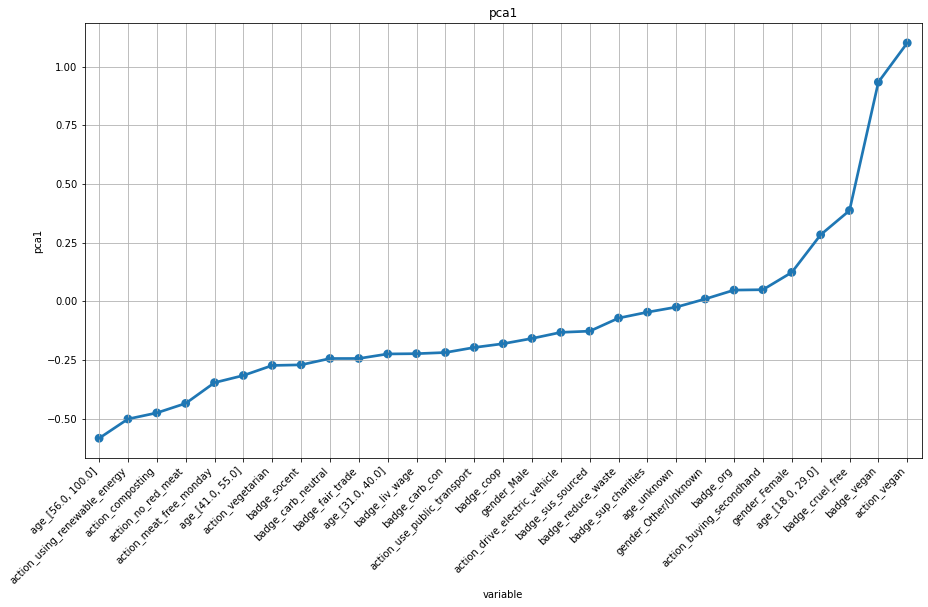

In [23]:
interpret_principal_component(user_data_onehot, user_data_onehot_pca, 'pca1')

Here we see that our vegans show a very strong relationship with PCA2 and the `badge_vegan` is strongly related to the `action_vegan`. It appears that the outlier we identified earlier dominates this principal component (I wonder what would happen to the other principal components if we were to remove these users, or these features?).

In 32.5% of users, the top three variables are all equal
In 27.6% of users, the bottom three variables are all equal


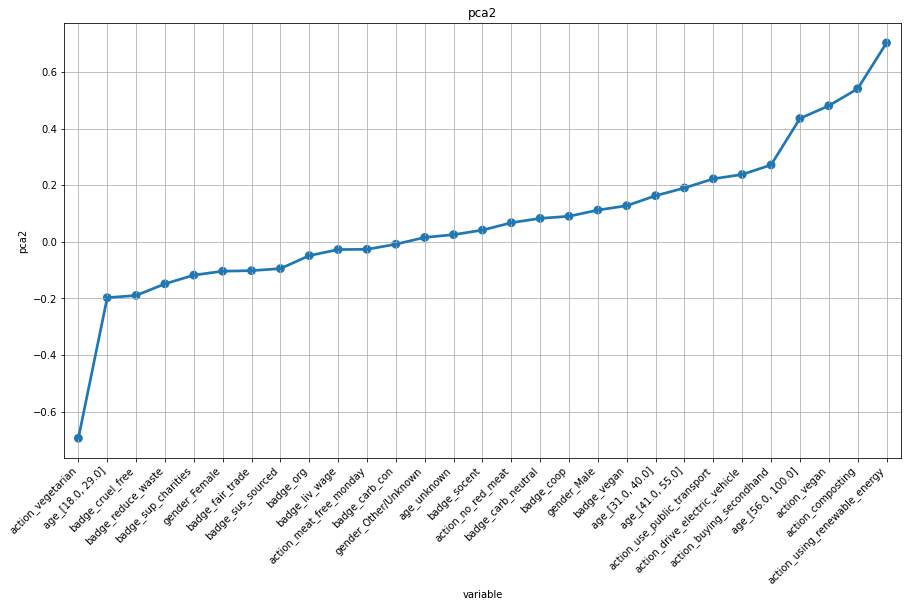

In [24]:
interpret_principal_component(user_data_onehot, user_data_onehot_pca, 'pca2')

Over a quarter of our sample is under 30, chose `badge_cruel_free` and commited to `action_vegetarian`.